
[pytorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [ ]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('/content/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/names/Arabic.txt', '/content/names/Chinese.txt', '/content/names/Italian.txt', '/content/names/Portuguese.txt', '/content/names/Greek.txt', '/content/names/Japanese.txt', '/content/names/English.txt', '/content/names/Czech.txt', '/content/names/Scottish.txt', '/content/names/Spanish.txt', '/content/names/Russian.txt', '/content/names/Dutch.txt', '/content/names/Irish.txt', '/content/names/Korean.txt', '/content/names/French.txt', '/content/names/German.txt', '/content/names/Vietnamese.txt', '/content/names/Polish.txt']
Slusarski


In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
import torch
import torch.nn as nn

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


rnn using the built in class

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        #self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        #self.h2o = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)

        self.rnn_layer = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        #combined = torch.cat((input, hidden), 1)
        hidden, _ = self.rnn_layer(input, hidden)
        hidden = hidden.reshape(hidden.shape[0], -1)
        output = self.fc(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8905, -2.8802, -2.9390, -2.8592, -2.8495, -2.9173, -2.8918, -2.7742,
         -2.9904, -2.9285, -2.9589, -2.8428, -3.0032, -2.7936, -2.8610, -2.8790,
         -2.8127, -2.9935]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

#print(categoryFromOutput(output))

In [ ]:
import random
random.seed(5)

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Ramsay
category = Dutch / line = Snaijer
category = Arabic / line = Quraishi
category = French / line = Hebert
category = Chinese / line = Lau
category = Portuguese / line = Moreno
category = German / line = Hermann
category = Irish / line = O'Donnell
category = Portuguese / line = Ventura
category = Czech / line = Betlach


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 3.6533 Shaw / Korean ✗ (Scottish)
10000 10% (0m 31s) 1.1661 Hadad / Arabic ✓
15000 15% (0m 48s) 4.8183 Shaw / Korean ✗ (Scottish)
20000 20% (1m 4s) 2.3842 Marshall / Scottish ✗ (English)
25000 25% (1m 19s) 1.6157 Chi / Chinese ✗ (Korean)
30000 30% (1m 35s) 0.0282 Kaloxylos / Greek ✓
35000 35% (1m 53s) 1.8223 Edmundson / Scottish ✗ (English)
40000 40% (2m 12s) 0.1344 Tanaka / Japanese ✓
45000 45% (2m 29s) 4.4427 Lee / Chinese ✗ (Korean)
50000 50% (2m 45s) 5.4998 Gerges / Dutch ✗ (Arabic)
55000 55% (3m 1s) 0.4138 Paitakes / Greek ✓
60000 60% (3m 16s) 0.1025 Corvi / Italian ✓
65000 65% (3m 32s) 0.9936 Pinho / Portuguese ✓
70000 70% (3m 48s) 1.9025 Doughty / Irish ✗ (English)
75000 75% (4m 3s) 1.7603 Cameron / Italian ✗ (Scottish)
80000 80% (4m 19s) 0.1264 Vamvakidis / Greek ✓
85000 85% (4m 36s) 2.0395 Etheridge / Spanish ✗ (English)
90000 90% (4m 54s) 1.5862 Crespo / Spanish ✗ (Portuguese)
95000 95% (5m 13s) 2.2456 Albuquerque / Portuguese ✗ (Spanish)
100000 100% (5m 31s)

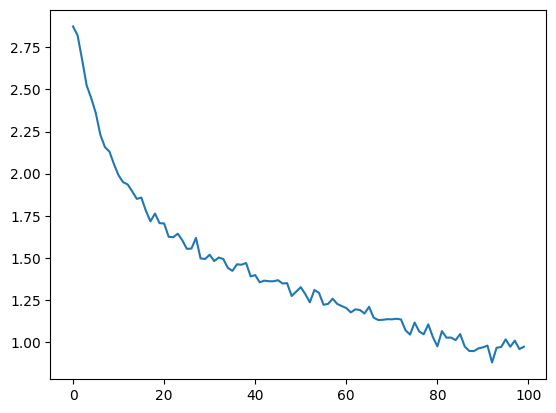

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-48-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-48-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


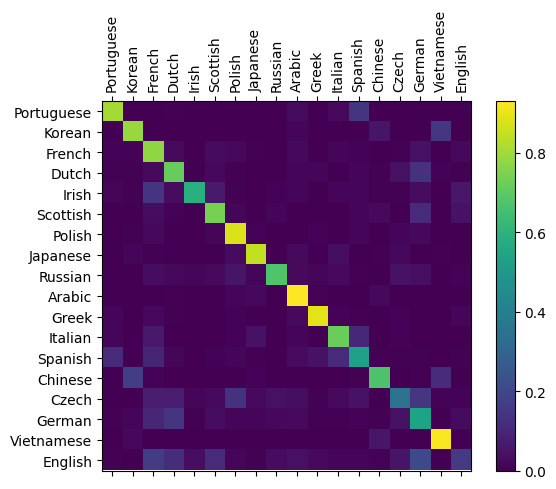

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.34) Russian
(-1.69) Czech
(-2.42) Polish

> Jackson
(-0.48) Scottish
(-1.15) English
(-3.82) French

> Satoshi
(-0.39) Japanese
(-1.23) Arabic
(-3.72) Italian


In [ ]:
predict('Celine')


> Celine
(-0.41) French
(-2.27) English
(-2.32) Irish


In [ ]:
predict('Emma')


> Emma
(-0.48) Czech
(-1.87) Japanese
(-2.18) Arabic


rnn from scratch

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

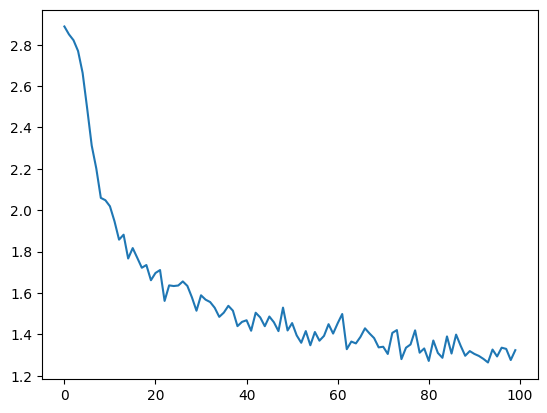

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-25-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-25-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


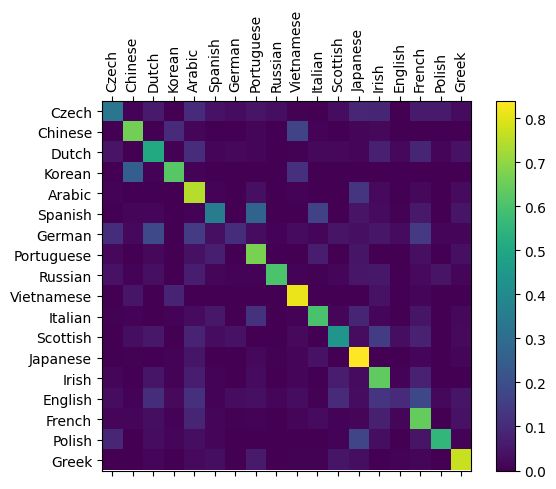

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.78) Russian
(-1.31) Irish
(-2.38) English

> Jackson
(-0.46) Scottish
(-1.88) English
(-2.99) Korean

> Satoshi
(-0.79) Arabic
(-0.95) Japanese
(-2.03) Italian


In [ ]:
predict('Celine')


> Celine
(-1.00) French
(-1.16) Scottish
(-2.40) Irish


In [ ]:
predict('Emma')


> Emma
(-1.02) Japanese
(-1.36) Czech
(-2.33) Arabic


In [ ]:
#LSTM

LSTM using the built in module

In [ ]:
import torch.nn as nn

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm_layer = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cparam):
        #combined = torch.cat((input, hidden), 1)
        out, _ = self.lstm_layer(input, (hidden, cparam))
        out = out.reshape(out.shape[0], -1)
        output = self.fc(out)
        output = self.softmax(output)
        return output, out

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    def initC(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn_lstm = RNN_LSTM(n_letters, n_hidden, n_categories)

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
cparam = torch.zeros(1, n_hidden)

output, out = rnn_lstm(input[0], hidden, cparam)
print(output)

tensor([[-2.8324, -3.0019, -2.8103, -2.9104, -2.8220, -2.9695, -2.9328, -2.8284,
         -2.9640, -2.8865, -2.9100, -2.8737, -2.9301, -2.9037, -2.9143, -2.8201,
         -2.8117, -2.9355]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
learning_rate = 0.01 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn_lstm.initHidden()
    cparam = rnn_lstm.initC()

    rnn_lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_lstm(line_tensor[i], hidden, cparam)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 33s) 2.9100 Reyer / Czech ✗ (French)
10000 10% (1m 7s) 2.8414 Jin / Irish ✗ (Chinese)
15000 15% (1m 40s) 2.7070 Nanami / Italian ✗ (Japanese)
20000 20% (2m 16s) 2.8555 Dopita / Japanese ✗ (Czech)
25000 25% (2m 50s) 2.5367 Ramsay / Russian ✗ (Scottish)
30000 30% (3m 23s) 1.9108 Villa / Japanese ✗ (Spanish)
35000 35% (3m 58s) 2.9236 Fiore / French ✗ (Italian)
40000 40% (4m 33s) 0.8168 Vestri / Italian ✓
45000 45% (5m 7s) 0.8692 Araujo / Portuguese ✓
50000 50% (5m 41s) 1.0326 Ferreira / Portuguese ✓
55000 55% (6m 17s) 0.9592 Sienkiewicz / Polish ✓
60000 60% (6m 51s) 0.9844 Phan / Vietnamese ✓
65000 65% (7m 25s) 1.6449 Lichtenberg / Dutch ✗ (German)
70000 70% (8m 0s) 1.5852 Close / Greek ✓
75000 75% (8m 35s) 3.9412 Gerges / Dutch ✗ (Arabic)
80000 80% (9m 8s) 1.1473 Doan / Vietnamese ✓
85000 85% (9m 42s) 0.7408 Bruce / Scottish ✓
90000 90% (10m 17s) 1.3829 Dolezal / Spanish ✗ (Czech)
95000 95% (10m 52s) 0.1211 Davlertgareev / Russian ✓
100000 100% (11m 26s) 1.5043 Patenaude / Ja

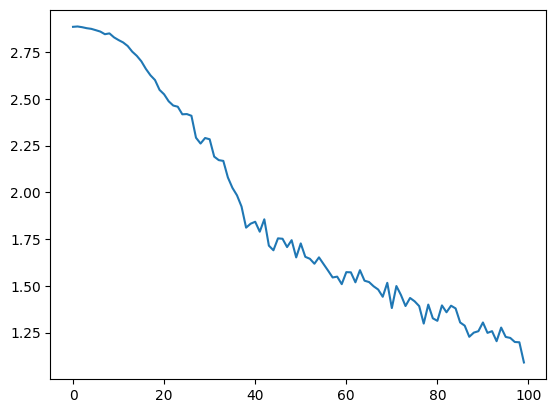

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
#val set score, test set score, play with hyperparams

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

LSTM from scratch

In [ ]:
import torch.nn as nn

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        #self.lstm_layer = nn.LSTM(input_size, hidden_size, batch_first=True)
        #self.fc = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)

        self.i_t = nn.Linear(input_size + hidden_size, hidden_size)
        self.f_t = nn.Linear(input_size + hidden_size, hidden_size)
        self.sigmoid1 = nn.Sigmoid()
        self.g_t = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh1 = nn.Tanh()
        self.o_t = nn.Linear(input_size + hidden_size, hidden_size)
        self.sigmoid2 = nn.Sigmoid()
        self.tanh2 = nn.Tanh()

        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cparam):
        #hidden, cparam = params[0], params[1]
        hidden = hidden.reshape(hidden.shape[0], -1)
        combined = torch.cat((input, hidden), 1)
        cparam = torch.squeeze(cparam)
        #print(combined.size())

        #out, _ = self.lstm_layer(input, (hidden, cparam))
        #out = out.reshape(out.shape[0], -1)
        #output = self.fc(out)
        #output = self.softmax(output)

        it = self.i_t(combined).squeeze()
        ft = self.sigmoid1(self.f_t(combined)).squeeze()
        gt = self.tanh1(self.g_t(combined)).squeeze()
        ot = self.sigmoid2(self.o_t(combined))
        out = self.fc(ot)
        out = self.softmax(out)

        cparam = torch.add(torch.multiply(ft,cparam), torch.multiply(it, gt))
        hidden = torch.multiply(ot, self.tanh2(cparam)).unsqueeze(dim = 0)

        return out, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    def initC(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn_lstm = RNN_LSTM(n_letters, n_hidden, n_categories)

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
cparam = torch.zeros(1, n_hidden)
params = (hidden, cparam)

output, hidden = rnn_lstm(input[0], hidden, cparam)
print(output)

tensor([-2.7508, -2.6142, -3.2502, -2.4273, -3.3133, -2.6611, -3.1925, -3.1804,
        -2.9045, -2.7044, -3.3587, -2.7349, -2.6101, -3.0759, -2.6421, -3.1022,
        -3.0860, -3.1221], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
print(hidden.size())

torch.Size([1])


In [ ]:
input.size()

torch.Size([6, 1, 57])

In [ ]:
learning_rate = 0.015 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn_lstm.initHidden()
    cparam = rnn_lstm.initC()

    rnn_lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_lstm(line_tensor[i], hidden, cparam)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 23s) 1.4891 Donovan / Irish ✓
10000 10% (0m 44s) 1.7296 Wasem / Vietnamese ✗ (Arabic)
15000 15% (1m 6s) 0.9667 Lai / Chinese ✓
20000 20% (1m 28s) 1.1890 Van / Chinese ✗ (Vietnamese)
25000 25% (1m 50s) 2.6524 Broz / Spanish ✗ (Polish)
30000 30% (2m 11s) 0.8704 Sun / Korean ✓
35000 35% (2m 33s) 0.7793 Vasquez / Spanish ✓
40000 40% (2m 54s) 2.3517 Loong / Korean ✗ (Chinese)
45000 45% (3m 16s) 6.0202 Jin / Scottish ✗ (Chinese)
50000 50% (3m 37s) 1.9221 Pontecorvo / Portuguese ✗ (Italian)
55000 55% (3m 59s) 0.6630 Diep / Vietnamese ✓
60000 60% (4m 20s) 1.7164 Palomo / Portuguese ✗ (Spanish)
65000 65% (4m 42s) 0.6510 Yang / Chinese ✓
70000 70% (5m 4s) 1.2060 Kuang / Korean ✗ (Chinese)
75000 75% (5m 25s) 2.1324 Maciomhair / French ✗ (Irish)
80000 80% (5m 48s) 3.1676 O'Connor / Scottish ✗ (Irish)
85000 85% (6m 9s) 0.9328 Zapatero / Spanish ✓
90000 90% (6m 31s) 0.0072 Fabrichnov / Russian ✓
95000 95% (6m 53s) 1.1628 Liu / Vietnamese ✗ (Chinese)
100000 100% (7m 14s) 0.6011 Wang / Chi

In [ ]:
category, line, category_tensor, line_tensor = randomTrainingExample()
print(category_tensor)

tensor([10])


In [ ]:
line_tensor.size()

torch.Size([8, 1, 57])

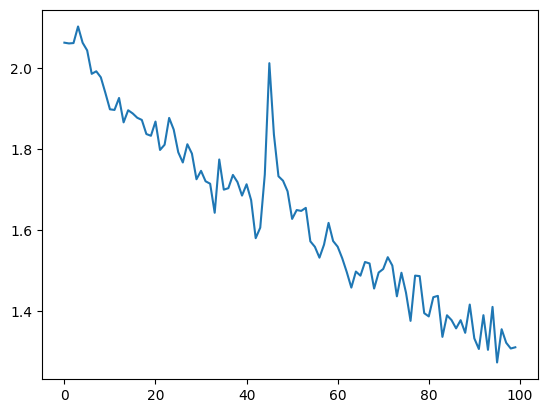

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-160-cc401880d42f>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-160-cc401880d42f>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


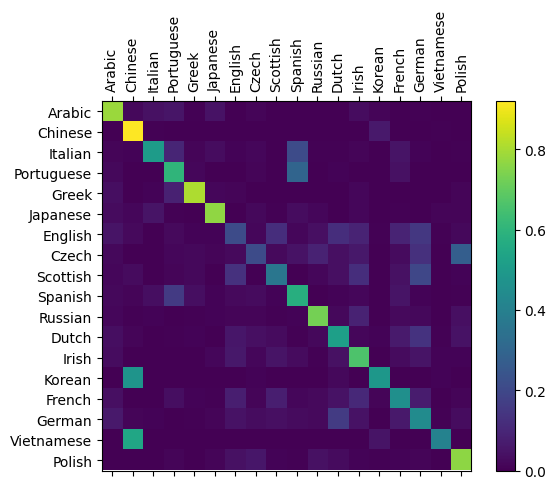

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn_lstm.initHidden()
    cparam = rnn_lstm.initC()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_lstm(line_tensor[i], hidden, cparam)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.44) Russian
(-1.66) Czech
(-2.18) Polish

> Jackson
(-1.29) Scottish
(-1.68) Polish
(-1.72) English

> Satoshi
(-0.87) Arabic
(-1.04) Japanese
(-1.74) Italian


In [ ]:
predict("Nil")


> Nil
(-0.74) Chinese
(-1.29) Korean
(-2.84) Arabic


In [ ]:
predict("Emma")


> Emma
(-0.77) Czech
(-1.87) Polish
(-2.09) Spanish
